# Run 'stockread.py' once every weekday. 
## It may take up to an hour to download data 
## (depending on net speed)

In [22]:
import sys
!python3 stockreader.py

Log file name : ./logs/log_2020-Mar-02-17-38-16.txt
andv data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
andv data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
andv data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
andv data.dict Empty ERROR -- Skipped
bf.b data.dict Empty ERROR -- Skipped
brk.b data.dict Empty ERROR -- Skipped
ggp data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Skipped
ggp data.dict  The file requested does not exist. Find full stock symbol available here: https://financialmodelingprep.com/api/v3/company/stock/list  ERROR -- Ski

# Import stockdatalib

In [1]:
import stockdatalib as sd

# Must set the data subdirectory

In [2]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')

# Load Data and plot a stock

<Figure size 1080x432 with 0 Axes>

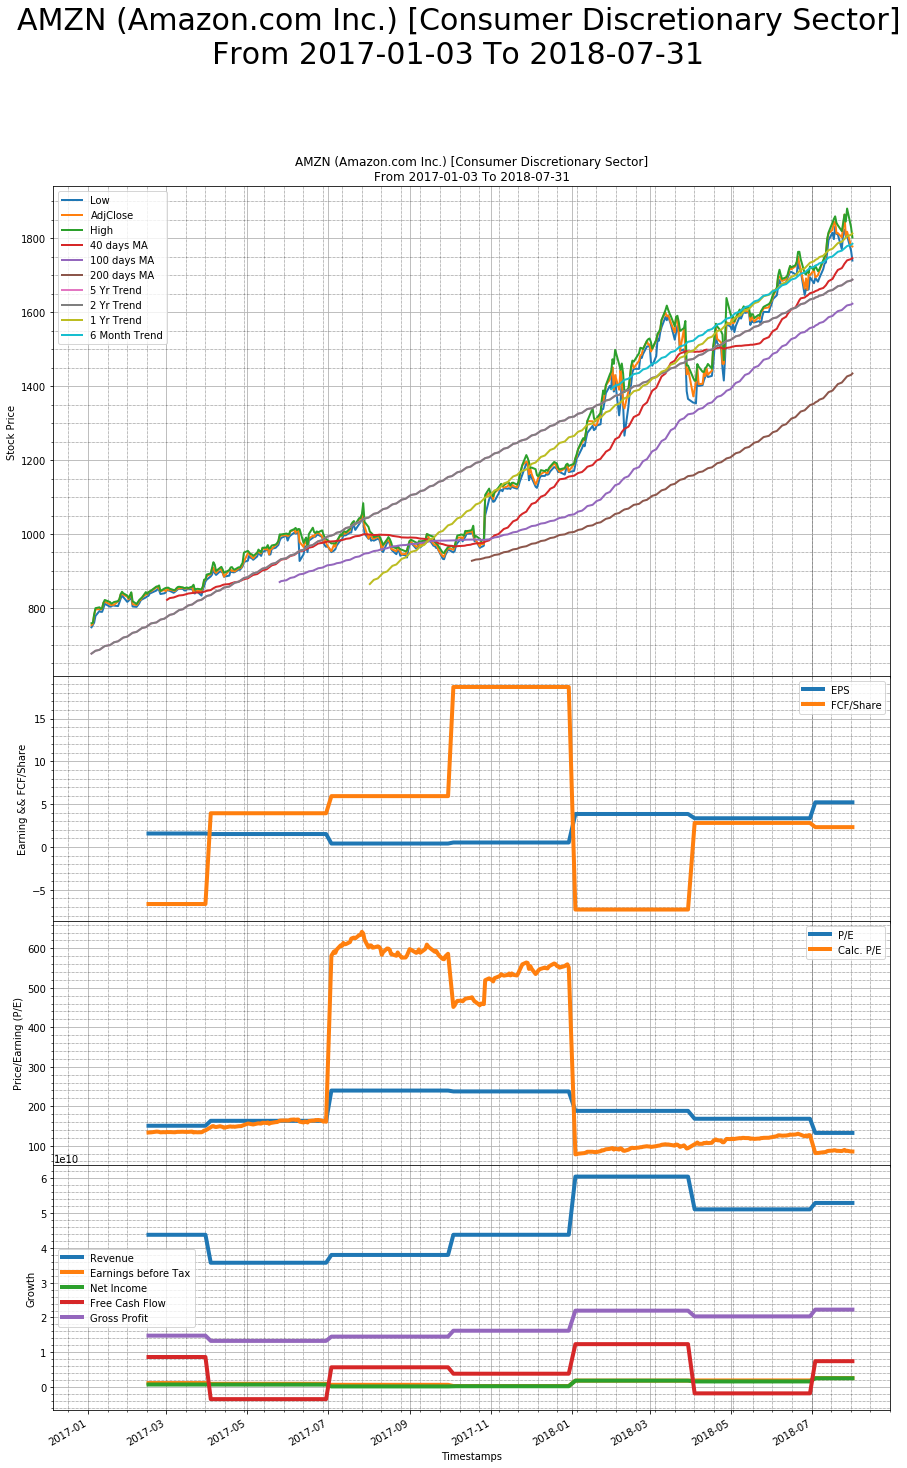

In [8]:
# Load S&P Stock list
stock_count, stock_fields, sp_df = sd.GetSP500_List()

# Set stock symbol
sd.set_stock('aapl')

stock_info = sd.get_stock_info('aapl')
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]

# Plot stock basic charts
price_df = sd.GetStockDataFrame('amzn')
price_df = sd.DatesRange(price_df, '2017-01-01','2018-08-01')
linear_trends = sd.plot_basic_charts('amzn',price_df)

In [5]:
# Linear Regression Equations returned by the plot call
linear_trends

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.1592 x + 124,0.1592 x + 124,0.1415 x + 149.5,0.2302 x + 160.2


In [6]:
# Get last price quote
sd.quote('csco')

,symbol,date,close,volume
0,csco,2020-03-02 21:00:01,41.17,46581395


In [7]:
# Get last key stats on the stock
sd.key_stat('ibm')

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,ibm,2019-09-30,887291199.0,1.802800e+10,1.522000e+09,16.7728,1.88,1.672000e+09,0.168127,8.335000e+09,3.597


,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,1.412 x + 279.5,0.5578 x + 1625,0.3382 x + 1801,2.242 x + 1701


<Figure size 1080x432 with 0 Axes>

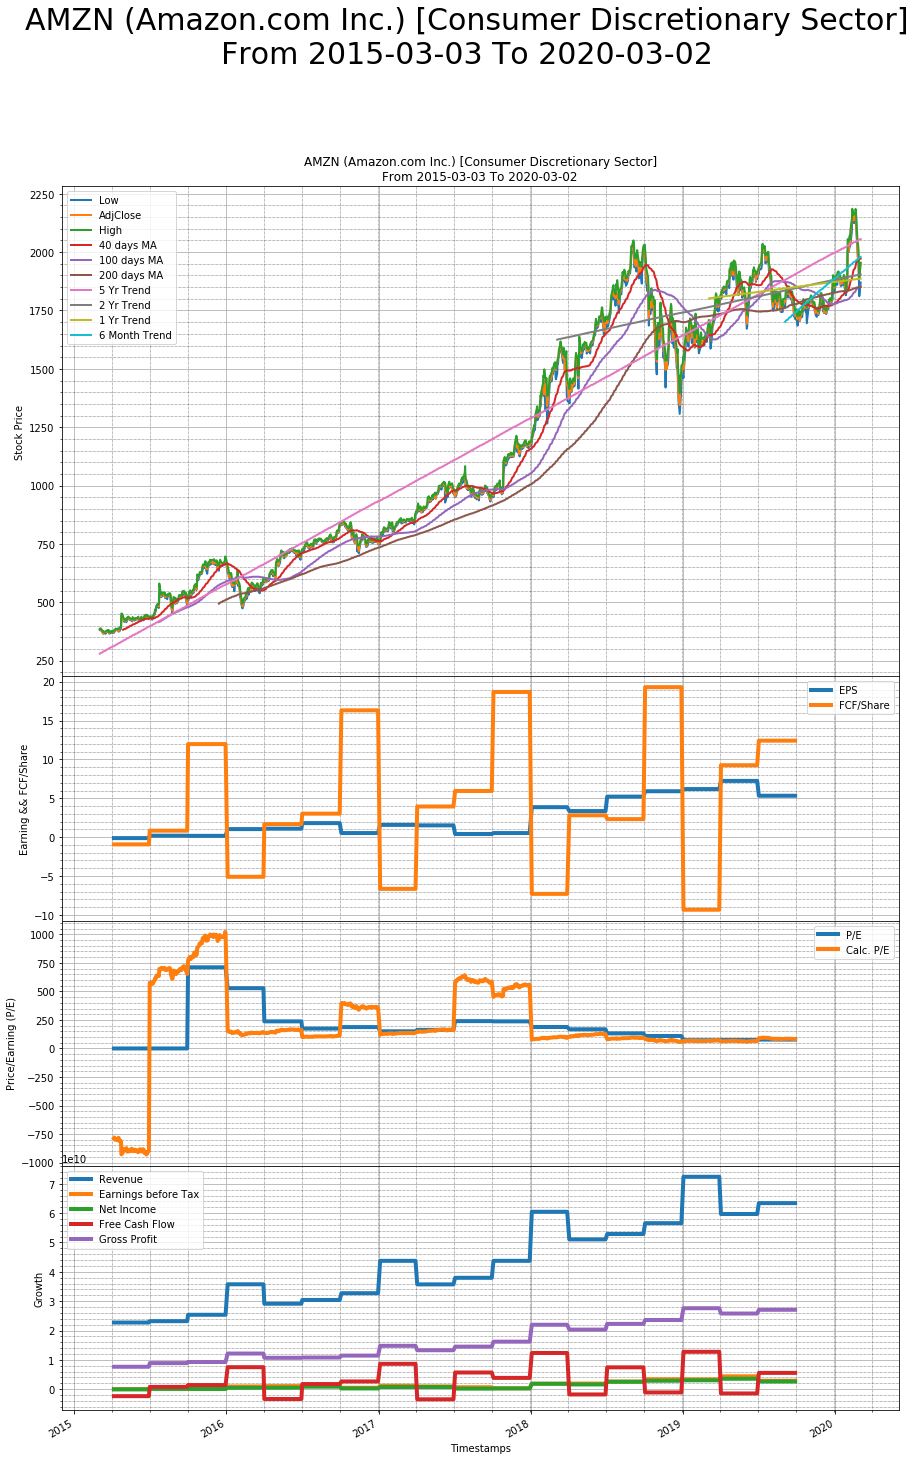

In [9]:
# Plot another stock
sd.plot_basic_charts('amzn')

# The data load functions

In [11]:
# Load stock End of Day prices file
price_df = sd.GetStockDataFrame('fb')

# Load the stock fundamental data
keys, column_map, main_df_org = sd.GetFund_Dict('fb')

# Searching for data by column name

In [12]:
# Search for a key word in the data column names
table,text = sd.FindColumn('Revenue')
table

,column_name,DataFrame
0,Revenue,income-statement
1,Revenue Growth,income-statement
2,Cost of Revenue,income-statement
3,Deferred revenue,balance-sheet-statement
4,Revenue per Share,company-key-metrics
5,SG&A to Revenue,company-key-metrics
6,R&D to Revenue,company-key-metrics
7,Capex to Revenue,company-key-metrics
8,Stock-based compensation to Revenue,company-key-metrics
9,profitabilityIndicatorRatios_eBITperRevenue,financial-ratios


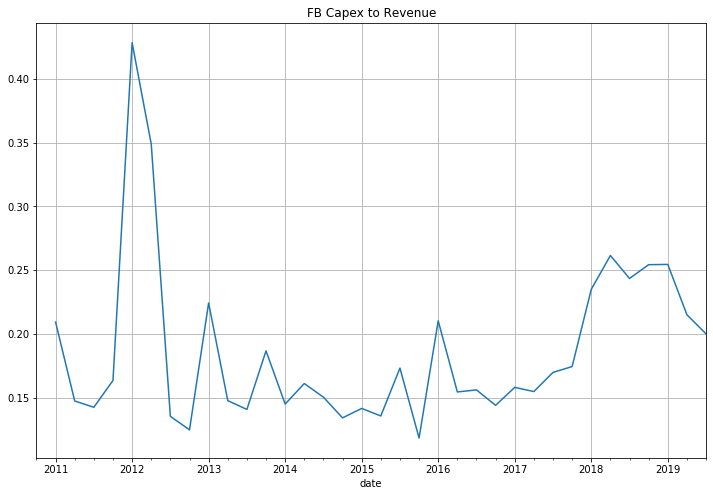

In [13]:
# Now we know where 'Capex to Revenue' is, we can load it from the DataFrame source 'company-key-metrics' as 
# the code below
main_df_org['company-key-metrics']['Capex to Revenue'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+' Capex to Revenue')

# Selecting data range from price data frame

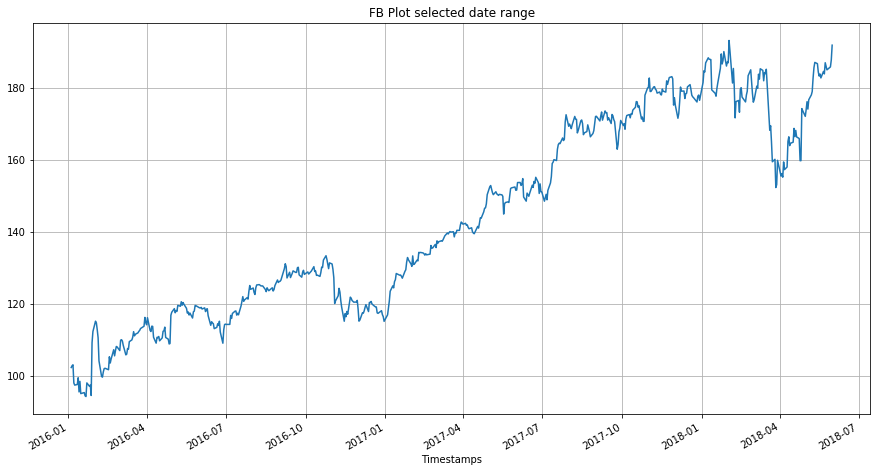

In [14]:
# Limit the stock prices data in the dates range
price_df = sd.DatesRange(price_df, '2016-01-01', '2018-06-01')

# Plot the prices chart
ax1 = price_df['AdjClose'].plot(figsize=(15,8),
                                title=sd.get_stock().upper()+" Plot selected date range").grid()

# Merging DataFrames from multiple sources into one DF

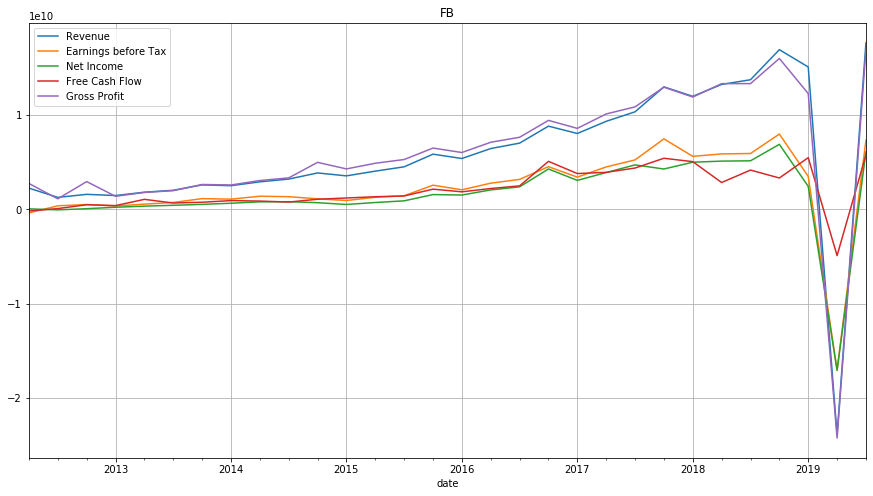

In [15]:
import pandas as pd

# Create a subset of columns in a DataFrame from the stock fundamentals dataset
cols = ['Revenue','Earnings before Tax','Net Income','Free Cash Flow margin','Gross Profit','Net Profit Margin'] # [ 'Shares', 'Price', 'Revenue', 'Earnings']
main_df1 = sd.MakeFund_Subset(main_df_org['income-statement'],cols)

# Create another subset of columns from another fundamentals dataset
cols = ['Number of Shares','Stock Price']
main_df2 = sd.MakeFund_Subset(main_df_org['enterprise-value'],cols)

# Create a 3rd subject of columns from yet another fundamentals dataset
cols = ['Capital Expenditure','Free Cash Flow']
main_df3 = sd.MakeFund_Subset(main_df_org['cash-flow-statement'],cols)

# Create a 4th subject of columns from yet another fundamentals dataset
cols = ['Free Cash Flow per Share']
main_df4 = sd.MakeFund_Subset(main_df_org['company-key-metrics'],cols)


# Merge the 3 dataframes into a single dataframe
main_df = pd.merge(main_df1,main_df2,on='date')
main_df = pd.merge(main_df,main_df3,on='date')
main_df = pd.merge(main_df,main_df4,on='date')

main_df.plot(y=['Revenue','Earnings before Tax','Net Income','Free Cash Flow','Gross Profit'],
             figsize=(15,8),title=sd.get_stock().upper()).grid()


# Using DatesRange() on fundamental data 

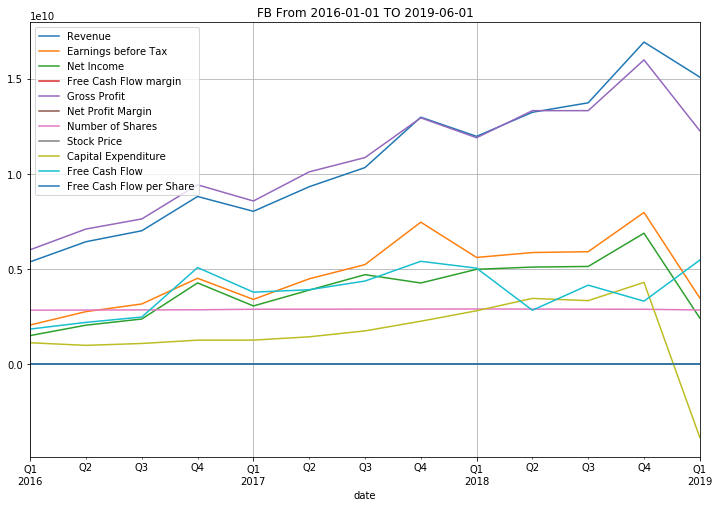

In [16]:
sd.DatesRange(main_df, '2016-01-01', '2019-06-01').plot(figsize=(12,8),
                                                                     grid=True,
                                                                     title=sd.get_stock().upper()+' From 2016-01-01 TO 2019-06-01')

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.2684 x + 42.12,-0.03652 x + 341.8,-0.1604 x + 351.6,0.8935 x + 258.3


<Figure size 1080x432 with 0 Axes>

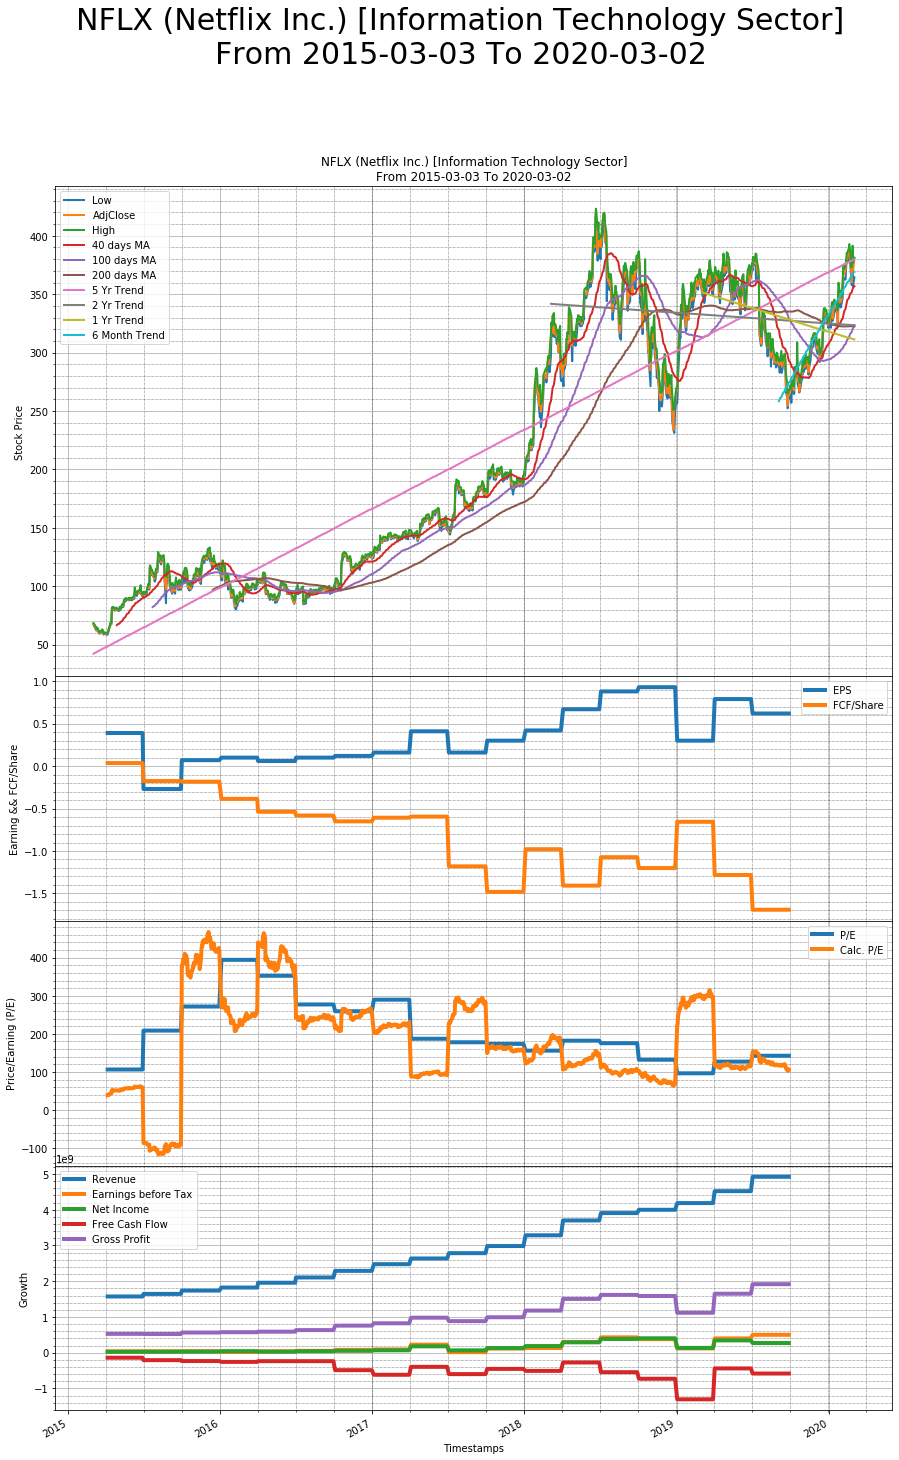

In [17]:
# Plot price chart with trend lines, EPS, and PE ratios
sd.plot_basic_charts('nflx')

# Plot a single key stat item

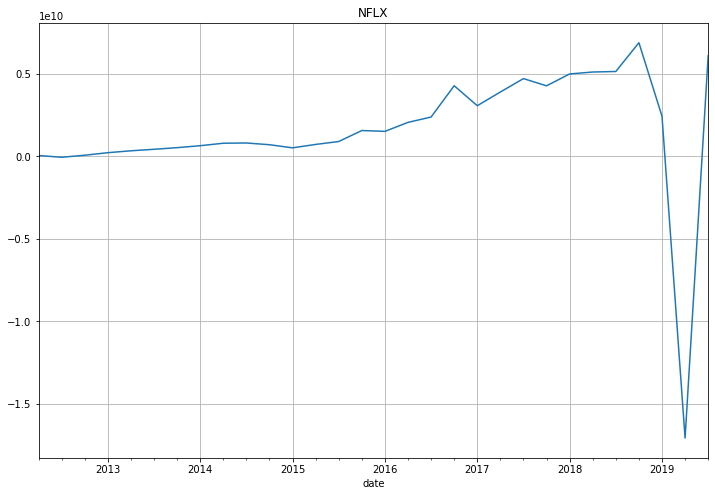

In [18]:
main_df['Net Income'].plot(figsize=(12,8), title = sd.get_stock().upper()).grid()

# Plot the TrendChart()

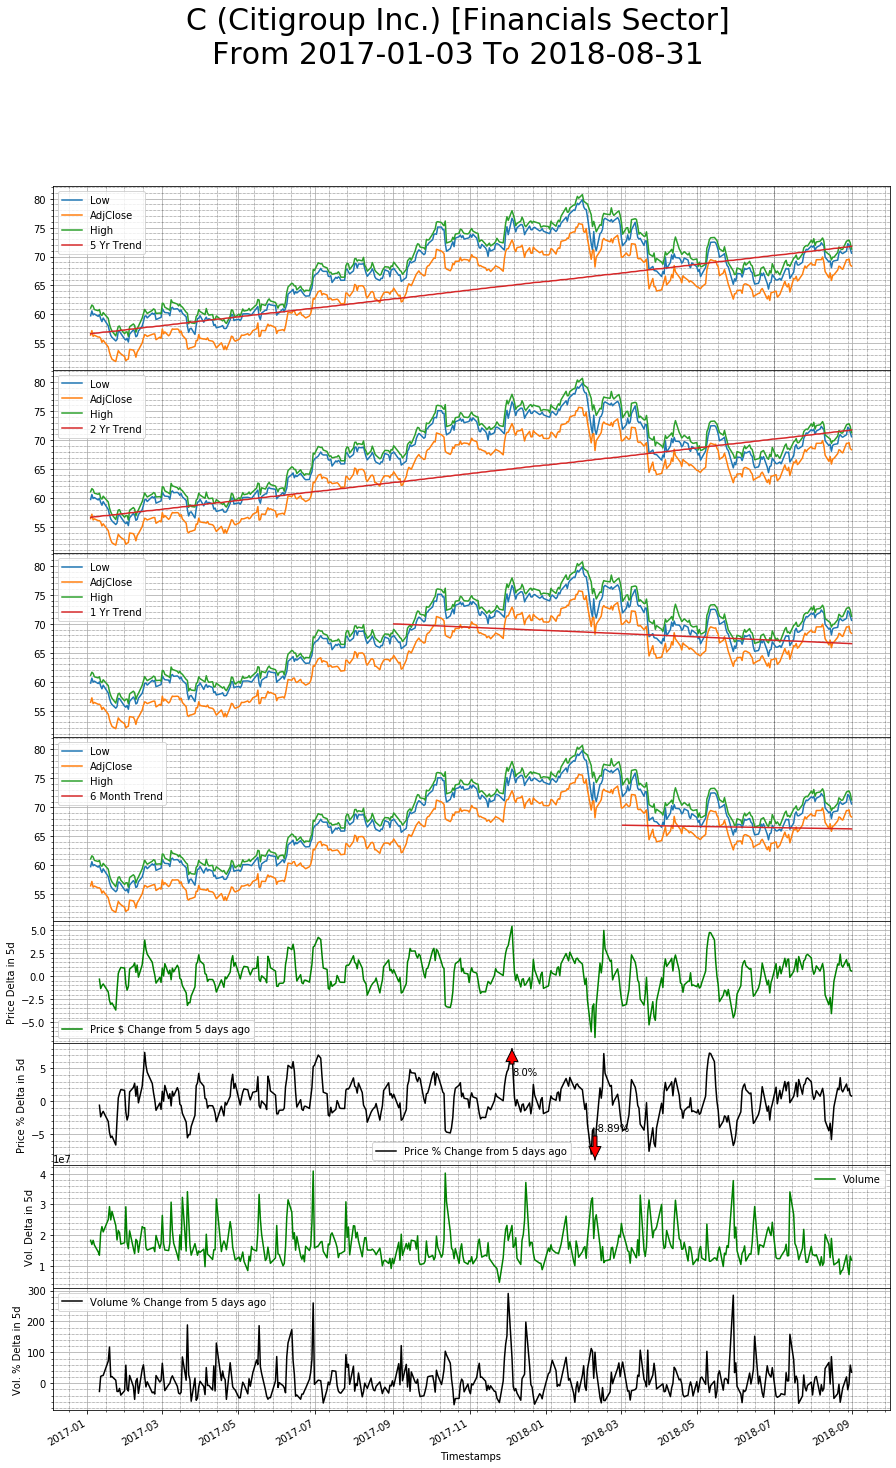

In [23]:
price_df = sd.GetStockDataFrame('c')
price_df = sd.DatesRange(price_df, '2017-01-01', '2018-09-01')
price_data_df, maximums_table_df = sd.TrendsPlot('c',price_df)

# Show the Maximums Table in price and volume

In [24]:
maximums_table_df

,Date,Price,Volume
Change Type,,,
Max % Rise,2017-12-04,8.0%,--
Max % Drop,2018-02-08,-8.89%,--
Max % Rise,2017-12-01,--,290.71%
Max % Drop,2017-10-19,--,-69.32%


In [25]:
price_data_df.describe()

,Open,High,Low,AdjClose,Volume,Price $ Change from 5 days ago,Price % Change from 5 days ago,Volume % Change from 5 days ago,5 Yr Trend,2 Yr Trend,1 Yr Trend,6 Month Trend
count,420.000000,420.000000,420.000000,420.000000,4.200000e+02,415.000000,415.000000,415.000000,420.000000,420.000000,252.000000,128.000000
mean,68.059286,68.632714,67.476857,64.211302,1.669607e+07,0.151873,0.280022,8.801581,64.211302,64.211302,68.262935,66.596374
std,6.004012,6.033319,5.956144,5.971171,5.526481e+06,1.766053,2.720045,50.264929,4.379181,4.379181,0.988132,0.186466
min,55.490002,56.209999,55.230000,51.864296,4.676100e+06,-6.651405,-8.886889,-69.320799,56.653390,56.653390,66.561605,66.277174
25%,61.877501,62.520000,61.615001,58.108585,1.298360e+07,-0.856285,-1.345816,-24.886275,60.432346,60.432346,67.412270,66.436774
50%,68.635002,69.224998,67.949997,64.964478,1.564005e+07,0.280991,0.457238,-1.869957,64.211302,64.211302,68.262935,66.596374
75%,72.535000,73.165001,72.029997,69.185184,1.864760e+07,1.325233,2.112965,26.271015,67.990257,67.990257,69.113600,66.755974
max,80.120003,80.699997,79.830002,75.676773,4.082720e+07,5.396034,7.998320,290.705930,71.769213,71.769213,69.964265,66.915574


# Search for a column containing 'cash flow' substring

In [26]:
f,s = sd.FindColumn('cash flow')
f

,column_name,DataFrame
0,Free Cash Flow margin,income-statement
1,Operating Cash Flow,cash-flow-statement
2,Investing Cash flow,cash-flow-statement
3,Financing Cash Flow,cash-flow-statement
4,Net cash flow / Change in cash,cash-flow-statement
5,Free Cash Flow,cash-flow-statement
6,Operating Cash Flow per Share,company-key-metrics
7,Free Cash Flow per Share,company-key-metrics
8,EV to Operating cash flow,company-key-metrics
9,EV to Free cash flow,company-key-metrics
